In [13]:
# ╭────────────────── 0. DEPENDENCIAS BÁSICAS ──────────────────╮
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import rna_utils as ru


DIST_PATH = "../../data/rnadist_f_all.h5"
SIM_PATH = "../../data/seqsim_f_all.h5"
META_PATH = "../../data/sources/ArchiveII_with_prob_and_motiv.csv"

In [14]:
dist, meta = ru.load_and_align(corr_path=DIST_PATH, meta_path=META_PATH)
sim, meta = ru.load_and_align(corr_path=SIM_PATH, meta_path=META_PATH)

# checks
assert dist.shape == sim.shape
assert (dist.index == dist.columns).all()
assert (sim.index == sim.columns).all()

In [15]:
meta.groupby("fam").sequence.agg("count")

fam
16s             66
23s             15
5s            1283
RNaseP         454
grp1            74
srp            918
tRNA           557
telomerase      35
tmRNA          462
Name: sequence, dtype: int64

In [27]:
def duplicate_ratio(subDF):
    A = subDF.values
    dup = (A == 0).sum() - len(A)  # zeros fuera de la diagonal
    total = len(A) * (len(A) - 1)
    return dup / total


meta.groupby("fam").apply(
    lambda g: duplicate_ratio(dist.loc[g.index, g.index])
).sort_values(ascending=False)

/tmp/ipykernel_3705557/3351561183.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meta.groupby("fam").apply(


fam
tRNA          0.041680
5s            0.007245
tmRNA         0.002554
srp           0.001509
RNaseP        0.001507
grp1          0.001111
16s           0.000000
23s           0.000000
telomerase    0.000000
dtype: float64

In [26]:
def duplicate_ratio(subDF):
    A = subDF.values
    dup = (A == 1).sum() - len(A)  # zeros fuera de la diagonal
    total = len(A) * (len(A) - 1)
    return dup / total


meta.groupby("fam").apply(
    lambda g: duplicate_ratio(sim.loc[g.index, g.index])
).sort_values(ascending=False)

/tmp/ipykernel_3705557/1703523402.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meta.groupby("fam").apply(


fam
tmRNA         0.001286
grp1          0.001111
srp           0.001048
tRNA          0.000717
RNaseP        0.000360
5s            0.000261
16s           0.000000
23s           0.000000
telomerase    0.000000
dtype: float64

In [16]:
# ╭────────── 2.1 CONSTRUIR SUB-MATRICES INTRA-FAMILIA ──────────╮
fam_corrs = ru.build_intra_fam_corrs(corr=dist, meta=meta)  # {fam: DataFrame}

In [17]:
# ╭────────── 2.2 HELPER: MEIDOIDE DE UN CLÚSTER ──────────╮
def medoid_of_cluster(D, members):
    """
    D          : matriz de distancias (ndarray n×n)
    members    : índices (int) dentro de D que pertenecen al clúster
    Devuelve   : índice (int) del miembro que minimiza la ∑ distancia.
    """
    if len(members) == 1:
        return members[0]
    sub = D[np.ix_(members, members)]
    return members[sub.sum(axis=1).argmin()]

In [18]:
# ╭────────── 2.3 LOOP POR FAMILIA → ÍNDICES REPRESENTANTES ──────────╮
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from tqdm import tqdm

rep_idx = []  # IDs (labels) de secuencias elegidas

for fam, subDF in tqdm(fam_corrs.items(), desc="Familias"):

    ids = subDF.index
    n = len(ids)

    # ——— Familias pequeñas: queda todo ———
    if n <= 200:
        rep_idx.extend(ids)
        continue

    # ——— Familias grandes: clustering jerárquico ———
    D = subDF.values
    Z = linkage(squareform(D, checks=False), method="average")
    labels = fcluster(Z, t=200, criterion="maxclust")  # 200 clusters

    # Medoide por clúster
    for k in np.unique(labels):
        members_local = np.where(labels == k)[0]
        rep_local = medoid_of_cluster(D, members_local)
        rep_idx.append(ids[rep_local])

Familias: 100%|██████████| 9/9 [00:00<00:00, 184.76it/s]


In [19]:
# ╭────────── 2.4 ARMAR NUEVO DATASET REDUCIDO ──────────╮
rep_idx = pd.Index(rep_idx, name="id")
dist_red = dist.loc[rep_idx, rep_idx].copy()  # matriz de distancias
sim_red = sim.loc[rep_idx, rep_idx].copy()  # matriz de similitud
meta_red = meta.loc[rep_idx].copy()  # metadatos filtrados

print("Shape dist_red :", dist_red.shape)
print("Familias       :", meta_red["fam"].value_counts().head())

Shape dist_red : (1165, 1165)
Familias       : fam
5s        200
tmRNA     200
RNaseP    200
srp       200
tRNA      175
Name: count, dtype: int64


In [20]:
# ╭────────── 2.4 ARMAR NUEVO DATASET REDUCIDO ──────────╮
rep_idx = pd.Index(rep_idx, name="id")
dist_red = dist.loc[rep_idx, rep_idx].copy()  # matriz de distancias
sim_red = sim.loc[rep_idx, rep_idx].copy()  # matriz de similitud
meta_red = meta.loc[rep_idx].copy()  # metadatos filtrados

print("Shape dist_red :", dist_red.shape)
print("Familias       :", meta_red["fam"].value_counts().head())

Shape dist_red : (1165, 1165)
Familias       : fam
5s        200
tmRNA     200
RNaseP    200
srp       200
tRNA      175
Name: count, dtype: int64


In [33]:
# ╭────────━━ 0. DEPENDENCIAS ━━────────╮
import numpy as np, pandas as pd, networkx as nx
from math import exp
import community as community_louvain  # pip install python-louvain
from tqdm import tqdm
from scipy.spatial.distance import squareform


# helper (medoid idéntico al de antes)
def medoid_of_cluster(D, members):
    sub = D[np.ix_(members, members)]
    return members[sub.sum(1).argmin()]


# ╭────────━━ 1. LOOP POR FAMILIA ━━────────╮
TARGET = 200  # nº deseado de representantes
kNN = 15  # vecinos por nodo para construir el grafo
BETA = 5.0  # controla caída del peso con la distancia
GAMMA_0 = 1.0  # resolución inicial de Louvain

rep_idx = []  # acumularemos aquí los IDs elegidos

for fam, subDF in tqdm(fam_corrs.items(), desc="Familias"):
    ids = subDF.index
    n = len(ids)
    if n <= TARGET:
        rep_idx.extend(ids)
        continue

    # 1.1 matriz → grafo esparso
    D = subDF.values
    G = nx.Graph()
    G.add_nodes_from(ids)

    for i, idi in enumerate(ids):
        nn = np.argsort(D[i])[1 : kNN + 1]  # k vecinos más cercanos
        for j in nn:
            idj = ids[j]
            w = exp(-BETA * D[i, j])
            G.add_edge(idi, idj, weight=w)

    # 1.2 Louvain con ajuste de resolución
    #      (aumentar gamma → más comunidades)
    gamma = GAMMA_0
    for _ in range(10):  # pequeño barrido
        part = community_louvain.best_partition(
            G, weight="weight", resolution=gamma, random_state=0
        )
        n_com = len(set(part.values()))
        if n_com >= TARGET:
            break
        gamma *= 1.2  # sube resolución si faltan clústers

    labels = pd.Series(part).map(dict(zip(G.nodes, range(len(G.nodes)))))
    labels = pd.Series(part).reindex(ids).astype(int).values  # ordenado igual que ids

    # 1.3 si aún sobran (>TARGET), une clústers más pequeños;
    #     si faltan (<TARGET), subdivide los más grandes con k-medoids (opcional).
    #     Para simplicidad quedémonos con los primeros TARGET distintos.
    unique = np.unique(labels)
    if len(unique) > TARGET:
        # Mapeo de cluster -> frecuencia y orden
        freq = pd.Series(labels).value_counts().sort_values(ascending=False)
        keep = set(freq.index[:TARGET])
        mask = np.array([lab in keep for lab in labels])
        ids = ids[mask]
        D = D[np.ix_(mask, mask)]
        labels = labels[mask]

    # 1.4 medoide por clúster final
    for cl in np.unique(labels):
        mem = np.where(labels == cl)[0]
        rep_idx.append(ids[medoid_of_cluster(D, mem)])

Familias: 100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


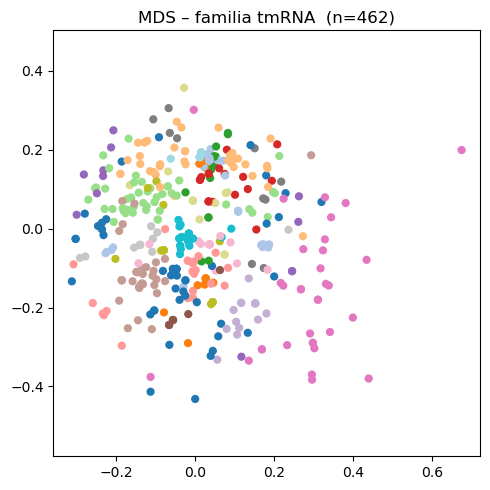

In [34]:
# ╭──────────  V1 · PROYECCIÓN 2-D (MDS)  ──────────╮
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

D = subDF.values
XY = MDS(dissimilarity="precomputed", random_state=0).fit_transform(D)

plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=XY[:, 0], y=XY[:, 1], hue=labels, palette="tab20", s=35, linewidth=0, legend=False
)
plt.title(f"MDS – familia {fam}  (n={len(ids)})")
plt.axis("equal")
plt.tight_layout()

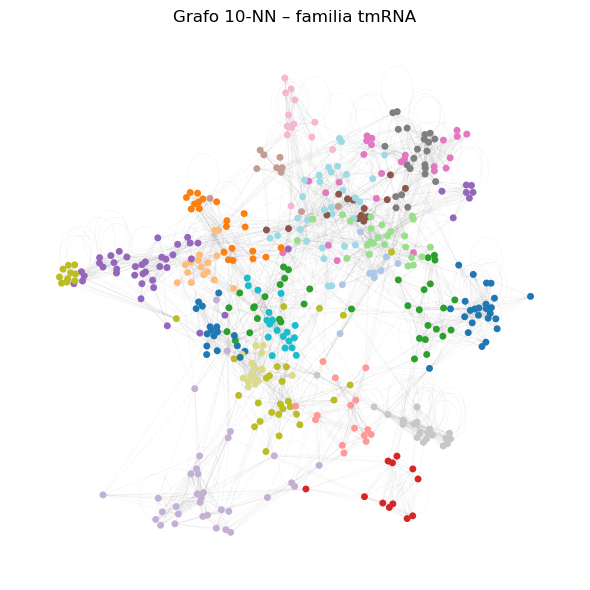

In [35]:
# ╭──────────  V3 · GRAFO k-NN CON LAYOUT SPRING  ──────────╮
import networkx as nx
from math import exp

kNN = 10  # nº de vecinos
BETA = 5.0  # misma β que antes

G = nx.Graph()
G.add_nodes_from(range(len(ids)))

for i in range(len(ids)):
    nn = np.argsort(D[i])[1 : kNN + 1]
    for j in nn:
        w = exp(-BETA * D[i, j])
        G.add_edge(i, j, weight=w)

pos = nx.spring_layout(G, seed=1, weight="weight")  # layout de fuerza

plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(
    G, pos, node_size=25, node_color=labels, cmap="tab20", linewidths=0
)
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.4)
plt.title(f"Grafo {kNN}-NN – familia {fam}")
plt.axis("off")
plt.tight_layout()

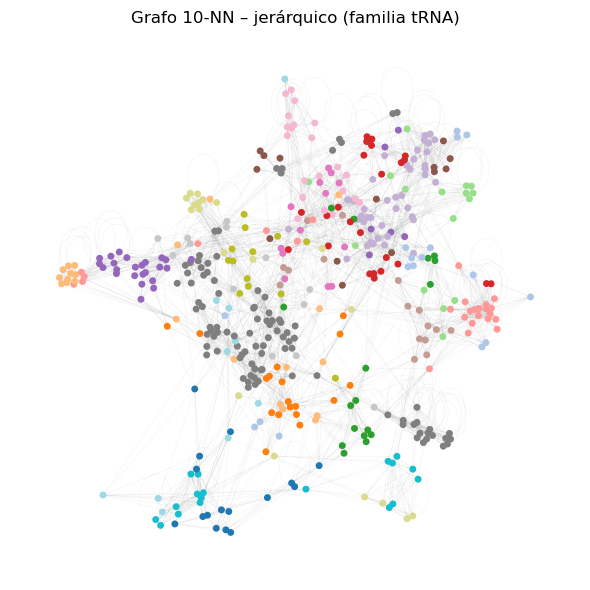

In [36]:
# ╭──────────  V3-H · GRAFO k-NN CON CLÚSTER JERÁRQUICO  ──────────╮
import numpy as np, matplotlib.pyplot as plt, networkx as nx
from math import exp
from scipy.cluster.hierarchy import linkage, fcluster

# --- variables de la familia que estás analizando ---
D = subDF.values  # sub-matriz de distancias (n×n) de la familia
ids = subDF.index  # mismo orden que D
fam = "tRNA"  # solo para el título

# 1. etiquetas jerárquicas (si ya las tienes, sáltate estas 3 líneas)
Z = linkage(squareform(D, checks=False), method="average")
labelsH = fcluster(Z, t=200, criterion="maxclust")  # ≤200 clusters

# 2. construir grafo k-NN (mismo k y β que antes)
kNN, BETA = 10, 5.0
G = nx.Graph()
G.add_nodes_from(range(len(ids)))

for i in range(len(ids)):
    nn = np.argsort(D[i])[1 : kNN + 1]
    for j in nn:
        w = exp(-BETA * D[i, j])
        G.add_edge(i, j, weight=w)

pos = nx.spring_layout(G, seed=1, weight="weight")  # layout de fuerza

# 3. plot
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=25,
    node_color=labelsH,  # ← colorea por jerárquico
    cmap="tab20",
    linewidths=0,
)
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.4)
plt.title(f"Grafo {kNN}-NN – jerárquico (familia {fam})")
plt.axis("off")
plt.tight_layout()

In [37]:
import networkx as nx


def largest_component_size(G: nx.Graph, return_ratio=False):
    """
    Devuelve el tamaño del componente conexo más grande.
    Si `return_ratio=True` devuelve además la fracción sobre |V|.
    """
    # lista de conjuntos de nodos; el más largo es el componente gigante
    giant = max(nx.connected_components(G), key=len)
    if return_ratio:
        return len(giant), len(giant) / G.number_of_nodes()
    return len(giant)


# --- ejemplo para la familia que estés analizando ---
size, ratio = largest_component_size(G, return_ratio=True)  # G = tu grafo
print(f"LCC size = {size}  ({ratio:.1%} del total de nodos)")

LCC size = 462  (100.0% del total de nodos)


In [39]:
# ╭────── 1. FUNCIÓN AUXILIAR · sub-matriz → grafo k-NN ─────╮
import networkx as nx
from math import exp
import numpy as np


def build_knn_graph(Dmat, k=10, beta=5.0):
    """
    Dmat : ndarray n×n de distancias (simétrica, diagonal 0)
    k    : nº de vecinos a conservar por nodo
    beta : factor de decaimiento en w = exp(-beta·d)
    Devuelve: G (networkx.Graph)
    """
    n = Dmat.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        nn = np.argsort(Dmat[i])[1 : k + 1]  # los k más cercanos (excluye i mismo)
        for j in nn:
            w = exp(-beta * Dmat[i, j])
            G.add_edge(i, j, weight=w)
    return G

In [40]:
# ╭────── 2. LOOP POR FAMILIA · calcular LCC ─────╮
kNN, BETA = 10, 5.0  # mismos parámetros que usaste antes
lcc_stats = {}  # fam → (size, ratio)

for fam, subDF in fam_corrs.items():
    n = len(subDF)
    if n <= 200:
        continue  # familias pequeñas: no hace falta filtrar

    G = build_knn_graph(subDF.values, k=kNN, beta=BETA)
    giant = max(nx.connected_components(G), key=len)
    size = len(giant)
    ratio = size / n

    lcc_stats[fam] = (size, ratio)
    print(f"{fam:<8}  LCC = {size:4d}  ({ratio:5.1%} de {n} nodos)")

5s        LCC = 1283  (100.0% de 1283 nodos)
RNaseP    LCC =  454  (100.0% de 454 nodos)
srp       LCC =  918  (100.0% de 918 nodos)
tRNA      LCC =  455  (81.7% de 557 nodos)
tmRNA     LCC =  462  (100.0% de 462 nodos)


In [41]:
graphs_by_fam = {}

for fam, subDF in fam_corrs.items():
    if len(subDF) <= 200:
        continue
    G = build_knn_graph(subDF.values, k=kNN, beta=BETA)
    graphs_by_fam[fam] = G  # ahora sí tienes el diccionario
    # ... resto del análisis ...

In [42]:
import networkx as nx


def largest_component_size(G: nx.Graph, return_ratio=False):
    """
    Devuelve el tamaño del componente conexo más grande.
    Si `return_ratio=True` devuelve además la fracción sobre |V|.
    """
    # lista de conjuntos de nodos; el más largo es el componente gigante
    giant = max(nx.connected_components(G), key=len)
    if return_ratio:
        return len(giant), len(giant) / G.number_of_nodes()
    return len(giant)


# --- ejemplo para la familia que estés analizando ---
size, ratio = largest_component_size(G, return_ratio=True)  # G = tu grafo
print(f"LCC size = {size}  ({ratio:.1%} del total de nodos)")

LCC size = 462  (100.0% del total de nodos)


In [43]:
lcc_stats = {}  # fam → (size, ratio)

for fam, subDF in fam_corrs.items():
    if len(subDF) <= 200:
        continue

    # recrea o reutiliza el grafo G de esa familia
    # (aquí asumo que ya lo construiste como en el pipeline anterior)
    G = graphs_by_fam[fam]  # por ejemplo

    size, ratio = largest_component_size(G, return_ratio=True)
    lcc_stats[fam] = (size, ratio)

# visualizar rápido
for fam, (s, r) in lcc_stats.items():
    print(f"{fam:<8}  LCC = {s:4d}  ({r:5.1%})")

5s        LCC = 1283  (100.0%)
RNaseP    LCC =  454  (100.0%)
srp       LCC =  918  (100.0%)
tRNA      LCC =  455  (81.7%)
tmRNA     LCC =  462  (100.0%)


In [44]:
# ╭────────── FUNCIÓN PRINCIPAL ─────────────────────────────────────────╮
import numpy as np, pandas as pd, networkx as nx
from math import exp


def build_graph(D, mode, param, beta=5.0):
    """
    D     : ndarray n×n de distancias (diagonal 0)
    mode  : 'knn'  -> param es k   (nº de vecinos conservados)
            'tau'  -> param es τ   (umbral mínimo de peso)
    beta  : factor de decaimiento en w = exp(-beta·d)
    Devuelve: nx.Graph esparso.
    """
    n = D.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))

    if mode == "knn":
        k = int(param)
        for i in range(n):
            nn = np.argsort(D[i])[1 : k + 1]  # k vecinos
            for j in nn:
                w = exp(-beta * D[i, j])
                G.add_edge(i, j, weight=w)

    elif mode == "tau":
        tau = float(param)
        rows, cols = np.where(np.triu(np.ones_like(D), 1))
        for i, j in zip(rows, cols):
            w = exp(-beta * D[i, j])
            if w >= tau:  # umbral de peso
                G.add_edge(i, j, weight=w)
    else:
        raise ValueError("mode debe ser 'knn' o 'tau'")

    return G


def lcc_vs_threshold(Dmat, mode, params, beta=5.0):
    """
    Calcula el tamaño y la fracción del LCC para cada valor de 'params'.

    Dmat   : DataFrame o ndarray de distancias (n×n)
    mode   : 'knn'  o  'tau'
    params : lista/array de k (int)   o τ (float) que quieres barrer
    beta   : igual que arriba
    Devuelve: DataFrame con columnas ['param', 'lcc_size', 'ratio']
    """
    D = np.asarray(Dmat)
    n = D.shape[0]
    rows = []

    for p in params:
        G = build_graph(D, mode, p, beta=beta)
        giant = max(nx.connected_components(G), key=len)
        lcc = len(giant)
        rows.append({"param": p, "lcc_size": lcc, "ratio": lcc / n})

    return pd.DataFrame(rows)

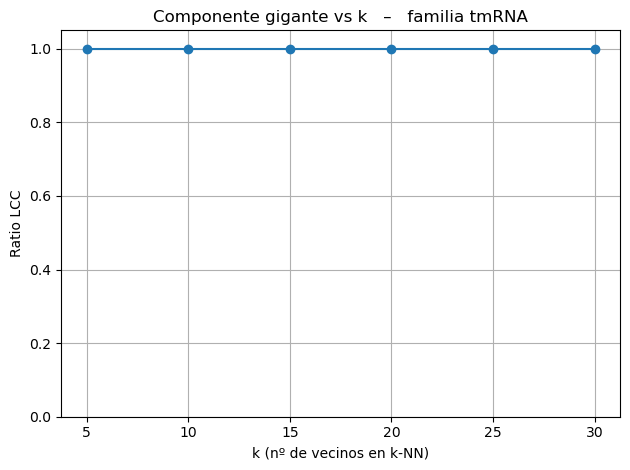

In [45]:
k_values = range(5, 31, 5)  # 5,10,15,20,25,30
df_k = lcc_vs_threshold(subDF.values, mode="knn", params=k_values, beta=5.0)

# --- gráfico ---
import matplotlib.pyplot as plt

plt.plot(df_k["param"], df_k["ratio"], marker="o")
plt.xlabel("k (nº de vecinos en k-NN)")
plt.ylabel("Ratio LCC")
plt.title(f"Componente gigante vs k   –   familia {fam}")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()

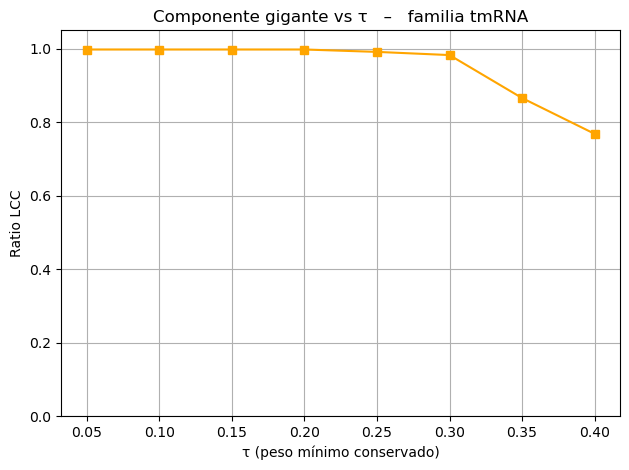

In [46]:
tau_values = np.linspace(0.05, 0.4, 8)  # de 0.05 a 0.4
df_tau = lcc_vs_threshold(subDF.values, mode="tau", params=tau_values, beta=5.0)

plt.plot(df_tau["param"], df_tau["ratio"], marker="s", color="orange")
plt.xlabel("τ (peso mínimo conservado)")
plt.ylabel("Ratio LCC")
plt.title(f"Componente gigante vs τ   –   familia {fam}")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()

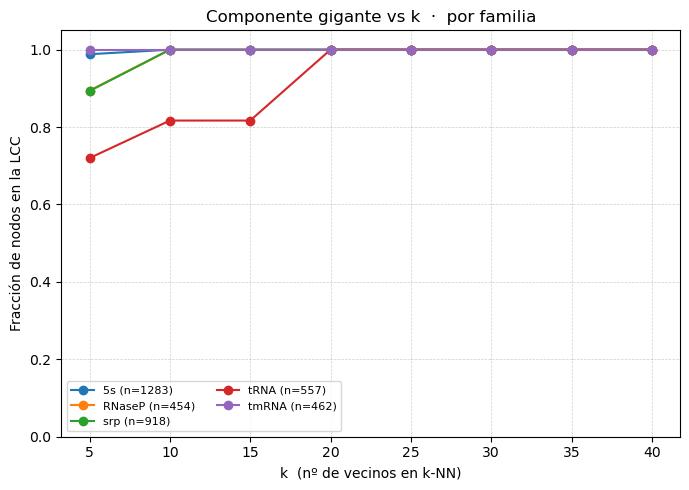

In [47]:
# ╭─────────  LOOP GLOBAL · LCC vs k PARA CADA FAMILIA GRANDE  ─────────╮
import matplotlib.pyplot as plt

# --- parámetros que quieres explorar ---
k_values = range(5, 41, 5)  # 5,10,15,…,40   (ajusta a gusto)
BETA = 5.0  # mismo β del peso w = exp(-β·d)

# --- diccionario para guardar resultados ---
lcc_curves = {}  # fam -> DataFrame con columnas param,lcc_size,ratio

fig, ax = plt.subplots(figsize=(7, 5))

for fam, subDF in fam_corrs.items():
    n = len(subDF)
    if n <= 200:
        continue  # familias pequeñas: se omiten

    df_k = lcc_vs_threshold(subDF.values, mode="knn", params=k_values, beta=BETA)
    lcc_curves[fam] = df_k

    # dibujo la curva en el mismo eje
    ax.plot(df_k["param"], df_k["ratio"], marker="o", label=f"{fam} (n={n})")

# --- cosmetics del plot ---
ax.set_xlabel("k  (nº de vecinos en k-NN)")
ax.set_ylabel("Fracción de nodos en la LCC")
ax.set_ylim(0, 1.05)
ax.set_title("Componente gigante vs k  ·  por familia")
ax.grid(True, ls="--", lw=0.5, alpha=0.6)
ax.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()